In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import ParticleOperator, generate_matrix
import numpy as np
import cirq
from src.lobe.system import System
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.asp import add_prepare_circuit, get_target_state
from src.lobe.rescale import bosonically_rescale_terms, rescale_terms_usp, get_number_of_active_bosonic_modes
from src.lobe._utils import get_basis_of_full_system

/Users/carterm.gustin/anaconda3/envs/phd/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


# Define Hamiltonian

In [3]:
renormalized_quartic_oscillator_hamiltonian = ParticleOperator({
    'a0^ a0^ a0^ a0': 2.849565686667622,
    'a0^ a0^': 3.5923247590513974,
    'a0^ a0^ a0 a0': -5.536050711865201,
    'a0^ a0': 11.737092068070014,
    'a0^ a0 a0 a0': 2.849565686667622,
    # # ' ': 2.4780255664185606, # remove identity term
    'a0 a0': 3.5923247590513974,
    'a0^ a0^ a0^ a0 a0 a0': 3.9998612759007717,
    'a0^ a0^ a0 a0 a0 a0': 3.5581095542809806,
})
terms = renormalized_quartic_oscillator_hamiltonian.to_list()

maximum_occupation_number = 3
number_of_modes = max([term.max_mode() for term in terms]) + 1

full_fock_basis = get_basis_of_full_system(number_of_modes, maximum_occupation_number, has_bosons=True)
matrix = generate_matrix(renormalized_quartic_oscillator_hamiltonian, full_fock_basis)

eigenvalues, eigenvectors = np.linalg.eig(matrix)
print(sorted(eigenvalues.round(3)))

[-1.815, 1.551, 14.217, 36.18]


# Rescale Hamiltonian

In [4]:
bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, maximum_occupation_number)
for term in bosonically_rescaled_terms:
    print(term)

0.7123914216669055 * a0^ a0^ a0^ a0

0.22452029744071234 * a0^ a0^

-1.3840126779663002 * a0^ a0^ a0 a0

0.7335682542543759 * a0^ a0

0.7123914216669055 * a0^ a0 a0 a0

0.22452029744071234 * a0 a0

3.9998612759007717 * a0^ a0^ a0^ a0 a0 a0

3.5581095542809806 * a0^ a0^ a0 a0 a0 a0



# Generate LOBE Circuit

{'left_elbows': 53, 'right_elbows': 45, 'rotations': 64, 'ancillae_tracker': [6, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 9, 10, 11, 10, 9, 10, 10, 11, 10, 9, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 9, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9], 'angles': [-0.024461720931042197, 0.024461720931042197, 0.024461720931042197, -0.024461720931042197, 0.0, -0.0, -1.3917369864908267, 1.3917369864908267, -0.16240570822686246, 0.047378980145554486, 0.047378980145554486, -0.16240570822686246, -0.3613671239067079, 0.3613671239067079, -1.514634787015289, 1.514634787015289, -0.08112519060694569, 0.04123210293217745, -0.04123210293217745, 0.08112519060694569, 0.0, -0.0, -1.2174757509268601, 1.2174757509268601, -0.2585219168796085, 0.09185525021294179, -0.011424626957775533, 0.17809129362444226, 0.0, -0.0, -1.3863539224187549, 1.3863539224187549, -0.024461720931042197, 0.0244617209310421

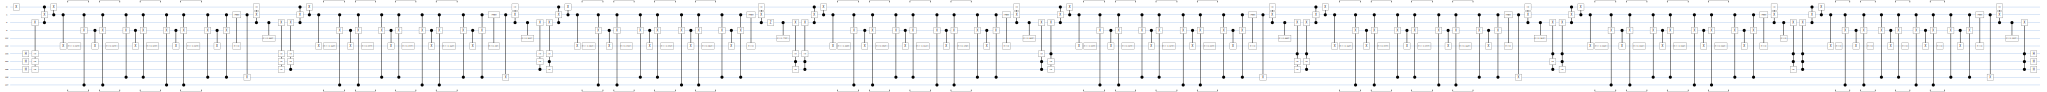

In [5]:
usp_rescaled_terms, usp_rescaling_factor = rescale_terms_usp(bosonically_rescaled_terms)

number_of_ancillae = 100
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1

USP_NUMERICS = {
    "left_elbows": 0,
    "right_elbows": 0,
    "rotations": 0,
    "ancillae_tracker": [
            1 + number_of_index_qubits + number_of_rotation_qubits
        ],
    "angles": []
}

block_encoding_scaling_factor = (1 << number_of_index_qubits)

# Declare Qubits
circuit = cirq.Circuit()
validation = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
rotation_qubits = [
    cirq.LineQubit(i + 1 + number_of_ancillae)
    for i in range(number_of_rotation_qubits)
]
index_register = [
    cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
    for i in range(number_of_index_qubits)
]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=1 + number_of_ancillae + number_of_rotation_qubits + number_of_index_qubits,
    has_fermions=False,
    has_antifermions=False,
    has_bosons=True,
)

# Generate full Block-Encoding circuit
circuit.append(cirq.X.on(validation))
circuit += add_naive_usp(index_register)
circuit += add_lobe_oracle(
    usp_rescaled_terms,
    validation,
    index_register,
    system,
    rotation_qubits,
    clean_ancillae,
    perform_coefficient_oracle=True,
    decompose=True, # flag to determine if controls should be decomposed to use more qubits, but fewer gates
    numerics=USP_NUMERICS
)
circuit += add_naive_usp(index_register)

print(USP_NUMERICS)
SVGCircuit(circuit)

# Validate Block-Encoding

In [6]:
upper_left_block = circuit.unitary(dtype=complex)[
    : 1 << system.number_of_system_qubits, : 1 << system.number_of_system_qubits
]
assert np.allclose(upper_left_block * block_encoding_scaling_factor * bosonic_rescaling_factor * usp_rescaling_factor, matrix)

### Overall Scaling Factor is:

$$
    S = 2^{\lceil \log_2{T} \rceil} * \max{|\alpha_i|} * (\Omega+1)^{B/2}
$$

where the variables are defined as follows:
- S: overall scaling factor of encoded Hamiltonian in block-encoding
- T: number of terms in Hamiltonian
- $\log_2{T}$: number of qubits used in index register
- $\alpha_i$: coefficient of term at index $i$
- $\max{|\alpha_i|}$: largest magnitude of all coefficients
- $\Omega$: maximum occupation number for bosonic modes
- $B$: maximum number of bosonic operators within a single term

In the code above, `scaling_factor` represents $\max{|\alpha_i|} * (\Omega+1)^{B/2}$ while `block_encoding_scaling_factor` represents $2^{\lceil \log_2{T} \rceil}$.

{'left_elbows': 53, 'right_elbows': 45, 'rotations': 62, 'ancillae_tracker': [6, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 9, 10, 11, 10, 9, 10, 10, 11, 10, 9, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9, 10, 10, 11, 10, 9, 10, 11, 10, 9, 10, 10, 11, 10, 11, 10, 11, 10, 9], 'angles': [2.061282625913431, 0.7054065238062082, -0.07907826672241614, 0.3833324609147778, -0.05766988229121431, 0.02019116314361971, -0.02019116314361971, -0.024461720931042197, 0.024461720931042197, 0.024461720931042197, -0.024461720931042197, 0.0, -0.0, -0.16240570822686246, 0.047378980145554486, 0.047378980145554486, -0.16240570822686246, -0.3613671239067079, 0.3613671239067079, -0.08112519060694569, 0.04123210293217745, -0.04123210293217745, 0.08112519060694569, 0.0, -0.0, -0.2585219168796085, 0.09185525021294179, -0.011424626957775533, 0.17809129362444226, 0.0, -0.0, -0.024461720931042197, 0.024461720931042197, -0.024461720

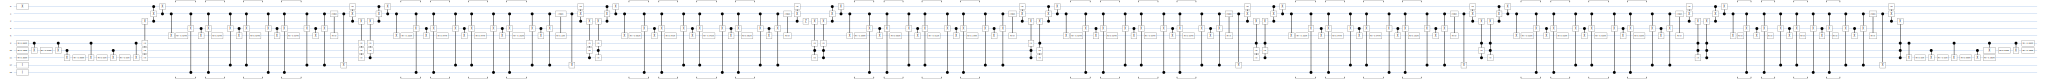

In [7]:
coefficients = [term.coeff for term in bosonically_rescaled_terms]
norm = sum(np.abs(coefficients))
target_state = get_target_state(coefficients)

number_of_ancillae = 5
number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1

ASP_NUMERICS = {
    "left_elbows": 0,
    "right_elbows": 0,
    "rotations": 0,
    "ancillae_tracker": [
            1 + number_of_index_qubits + number_of_rotation_qubits
        ],
    "angles": []
}

# Declare Qubits
circuit = cirq.Circuit()
validation = cirq.LineQubit(0)
clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
rotation_qubits = [
    cirq.LineQubit(i + 1 + number_of_ancillae)
    for i in range(number_of_rotation_qubits)
]
# rotation_qubits = [None] + rotation_qubits
index_register = [
    cirq.LineQubit(i + 1 + number_of_ancillae + 3)
    for i in range(number_of_index_qubits)
]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=1 + number_of_ancillae + 3 + number_of_index_qubits,
    has_fermions=False,
    has_bosons=True,
)
for bosonic_reg in system.bosonic_system:
    circuit.append(cirq.I.on_each(*bosonic_reg))

# Generate full Block-Encoding circuit
circuit.append(cirq.X.on(validation))
circuit += add_prepare_circuit(index_register, target_state=target_state, numerics=ASP_NUMERICS)
circuit += add_lobe_oracle(
    bosonically_rescaled_terms,
    validation,
    index_register,
    system,
    rotation_qubits,
    clean_ancillae,
    perform_coefficient_oracle=False,
    decompose=True,
    numerics=ASP_NUMERICS
)
circuit += add_prepare_circuit(index_register, target_state=target_state, dagger=True, numerics=ASP_NUMERICS)

# with open("lobe.svg", "w") as f:
#     f.write(SVGCircuit(circuit)._repr_svg_())

print(ASP_NUMERICS)
SVGCircuit(circuit)

In [8]:
upper_left_block = circuit.unitary(dtype=complex)[
    : 1 << system.number_of_system_qubits, : 1 << system.number_of_system_qubits
]
assert np.allclose(upper_left_block * norm * bosonic_rescaling_factor, matrix)

## Compare Renormalized vs. Unrenormalized

In [11]:
g = 1
Hfull = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4

In [24]:
from src.lobe.lobe_circuit import lobe_circuit

_, full_USP_NUMERICS, _, _ = lobe_circuit(Hfull, 200, 'usp')
_, full_ASP_NUMERICS, _, _ = lobe_circuit(Hfull, 200, 'asp')
_, ren_USP_NUMERICS, _, _  = lobe_circuit(renormalized_quartic_oscillator_hamiltonian, 3, 'usp')
_, ren_ASP_NUMERICS, _, _  = lobe_circuit(renormalized_quartic_oscillator_hamiltonian, 3, 'asp')

$\underline{\text{Without Renormalization}}$

$\underline{USP}$
* Left Elbows: 4,454
* Right Elbows: 4,437
* Rotations: 4,420
* Number of ancillae: 19
* $\lambda_{USP} = 1,292,832.0$

$\underline{ASP}$
* Left Elbows: 4,454
* Right Elbows: 4,437
* Rotations: 4,448
* Number of ancillae: 19
* $\lambda_{ASP} = 646,617.0$ 

$\underline{\text{With Renormalization}}$

$\underline{USP}$
* Left Elbows: 53
* Right Elbows: 45
* Rotations: 64
* Number of ancillae: 5
* $\lambda_{USP} = 2047.93$

$\underline{ASP}$
* Left Elbows: 53
* Right Elbows: 45
* Rotations: 62
* Number of ancillae: 5
* $\lambda_{ASP} = 739.16$ 